In [2]:
%load_ext autoreload

In [54]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

# sys.path.append('../..')
sys.path.append('..')

from data_utils import *

# sys.path.append('../../../DeLASE')
sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../sci_style.py')

# Create Session List

In [17]:
dt = 0.001

In [82]:
figure_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/plots'
os.makedirs(figure_dir, exist_ok=True)

In [18]:
session_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'
data_processing_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/data_processing_args'

In [ ]:
session_results[session]['vlPFC']

In [42]:
session_results = {}
session_metadata = {}
for session in tqdm(os.listdir(session_results_dir)):
    if np.array([session in f for f in os.listdir(data_processing_dir)]).sum() == 0:
        # LOAD DATA
        all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
        data_class = get_data_class(session, all_data_dir)

        os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
        # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
        # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
        # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

        variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
        session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
        electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']
        
        eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
        eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

        section_times = dict( 
                wake=(0, session_info['drugStart'][0]),
                induction=(session_info['drugStart'][0], eyes_close),
                anesthesia=(eyes_close, session_info['drugEnd'][1]),
                recovery=(session_info['drugEnd'][1], T*dt)
        )
        sections = list(section_times.keys())
        
        session_metadata[session] = {}
        session_metadata[session]['session_info'] = session_info
        session_metadata[session]['section_times'] = sections
        session_metadata[session]['sections'] = sections
        session_metadata[session]['eyes_open'] = eyes_open
        session_metadata[session]['eyes_close'] = eyes_close
        
        session_results[session] = {}
        # LOAD RESULTS
        max_freq = 500
        max_unstable_freq = 125
        for area in os.listdir(os.path.join(session_results_dir, session)):
            session_results[session][area] = None
            for f in os.listdir(os.path.join(results_dir, session, area)):
                t = float(f.split('_')[0])
                df = pd.DataFrame(pd.read_pickle(os.path.join(results_dir, session, area, f)))
                df['area'] = area
                df['start_time'] = t
                df['end_time'] = t + df.window*dt
                df['start_ind'] = int(t/dt)
                df['end_ind'] = int(t/dt) + df.window

                for i in range(len(df)):
                    filtered_inds = np.abs(df.stability_freqs.iloc[i]) <= max_freq
                    df.loc[[df.index[i]], 'stability_params'] = df.iloc[i:i+1].stability_params.apply(lambda x: x[filtered_inds])
                    df.loc[[df.index[i]], 'stability_freqs'] = df.iloc[i:i+1].stability_freqs.apply(lambda x: x[filtered_inds])

                    filtered_inds = np.logical_or(np.abs(df.stability_freqs.iloc[i]) <= max_unstable_freq, df.iloc[i].stability_params <= 0)
                    df.loc[[df.index[i]], 'stability_params'] = df.iloc[i:i+1].stability_params.apply(lambda x: x[filtered_inds])
                    df.loc[[df.index[i]], 'stability_freqs'] = df.iloc[i:i+1].stability_freqs.apply(lambda x: x[filtered_inds])

                if session_results[session][area] is None:
                    session_results[session][area] = df
                else:
                    session_results[session][area] = pd.concat([session_results[session][area], df])
                session_results[session][area] = session_results[session][area].sort_values('start_time')

  0%|          | 0/8 [00:00<?, ?it/s]

In [106]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}
area_labels = {
    'CPB': 'STG (auditory cortex)',
    '7b': 'PPC (parietal cortex)',
    'FEF': 'FEF (frontal eye fields)',
    'vlPFC': 'PFC (prefrontal cortex)',
    'all': 'all areas'
}

section_colors = {
    'wake': 'limegreen',
    'anesthesia': 'plum',
    'recovery': 'orange'
}

# Plot 1

In [70]:
sessions_to_plot = list(session_results.keys())

In [71]:
sessions_to_plot = sessions_to_plot[:2][::-1]

In [72]:
top_percent = 3
percentile_str = f"Top {top_percent}% of Stability Parameters"

In [99]:
title_fontsize = 36
axis_fontsize = 30
axis_ticklabel_fontsize = 26
legend_fontsize = 26

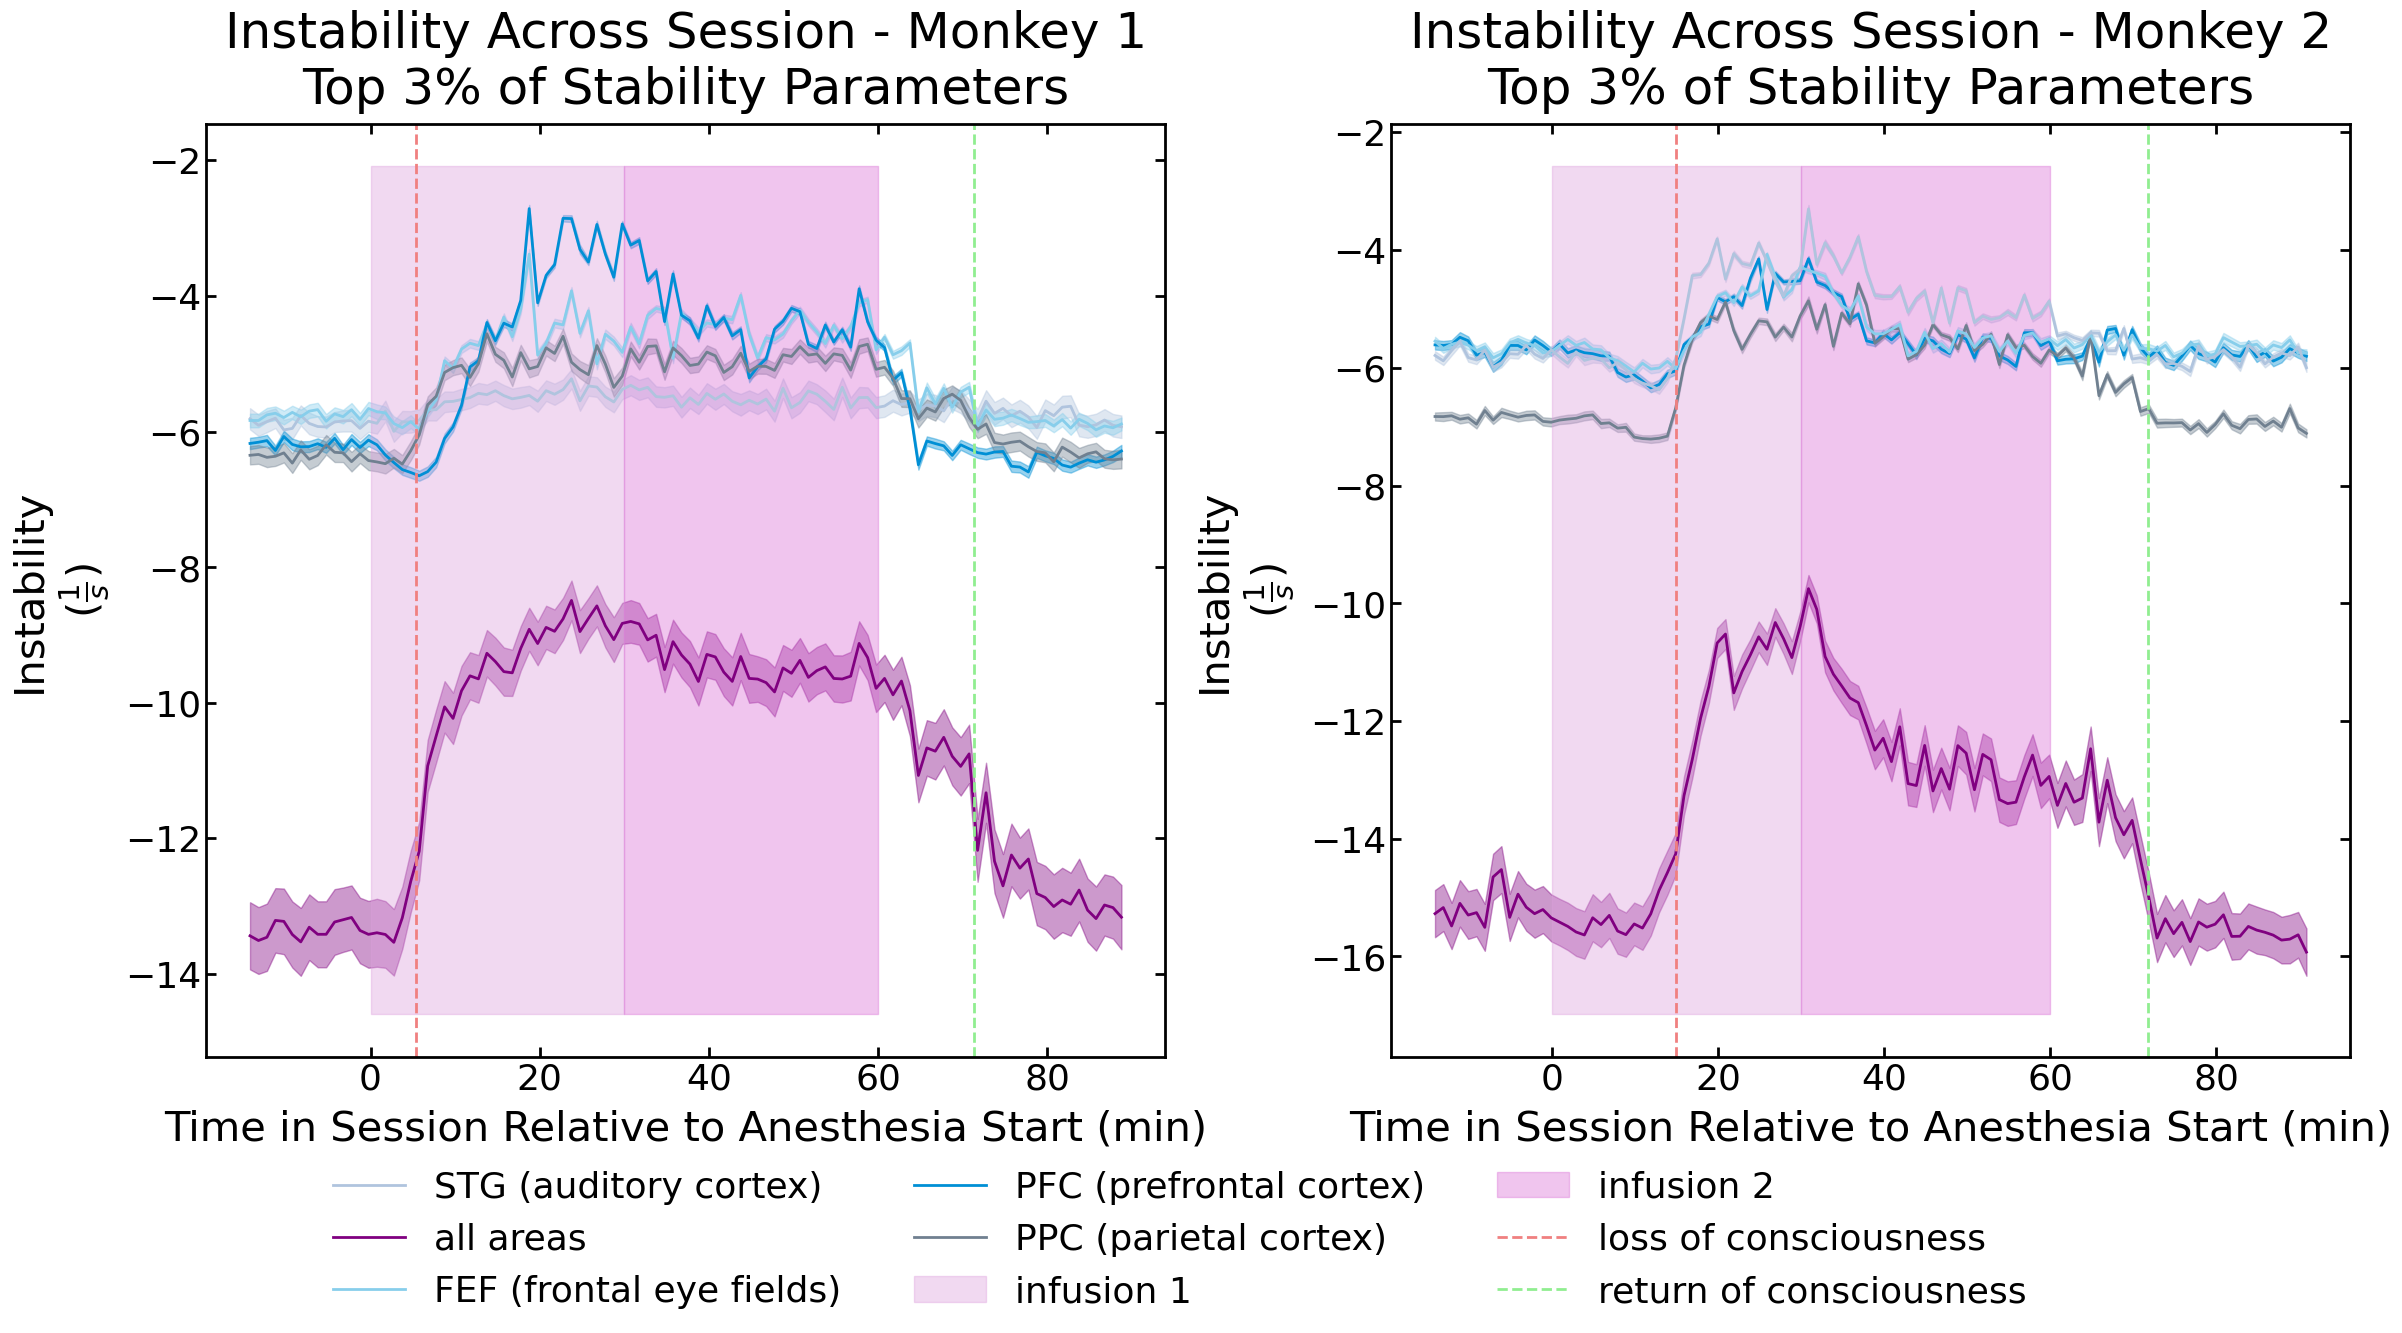

In [100]:
fig, axs = plt.subplots(1, len(sessions_to_plot), figsize=(24, 12))
for i, session in enumerate(sessions_to_plot):
    if i == 0:
        lns = []
    ax = axs[i]
    results_dict = session_results[session]
    session_info = session_metadata[session]['session_info']
    eyes_open = session_metadata[session]['eyes_open']
    eyes_close = session_metadata[session]['eyes_closed']
    filter_inds = np.logical_and(results_dict[list(results_dict.keys())[0]].start_time >= session_info['drugStart'][0] - 15*60, results_dict[list(results_dict.keys())[0]].start_time <= eyes_open + 20*60)
    time_vals = (results_dict[list(results_dict.keys())[0]][filter_inds].start_time - session_info['drugStart'][0])/60
    for area in results_dict.keys():
        if area:
            stability_mean = results_dict[area][filter_inds].stability_params.apply(lambda x: x[:int((top_percent/100)*len(x))].mean())
            stability_std_error = results_dict[area][filter_inds].stability_params.apply(lambda x: x[:int((top_percent/100)*len(x))].std()/np.sqrt(int((top_percent/100)*len(x))))
            ln = ax.plot(time_vals, stability_mean, color=area_colors[area], label=area_labels[area])
            if i == 0:
                lns += ln
            ax.fill_between(time_vals, stability_mean - stability_std_error, stability_mean + stability_std_error, color=area_colors[area], alpha=0.4)
    # title_str = f"{session}\n{percentile_str}"
    monkey_num = 2 if 'Jones' in session else 1
    title_str = f"Instability Across Session - Monkey {monkey_num}\n{percentile_str}"
    ax.set_title(title_str, fontsize=title_fontsize)
    ax.set_xlabel('Time in Session Relative to Anesthesia Start (min)', fontsize=axis_fontsize)
    ax.set_ylabel('Instability\n' r'($\frac{1}{s}$)', fontsize=axis_fontsize)
    ylim = ax.get_ylim()
    ln1 = ax.fill_betweenx(ylim, (session_info['drugStart'][0] - session_info['drugStart'][0])/60, (session_info['drugEnd'][0] - session_info['drugStart'][0])/60, color='plum', alpha=0.4, label='infusion 1')
    ln2 = ax.fill_betweenx(ylim, (session_info['drugStart'][1] - session_info['drugStart'][0])/60, (session_info['drugEnd'][1] - session_info['drugStart'][0])/60, color='orchid', alpha=0.4, label='infusion 2')
    ln3 = ax.axvline((eyes_close - session_info['drugStart'][0])/60, linestyle='--', color='lightcoral', label='loss of consciousness')
    ln4 = ax.axvline((eyes_open - session_info['drugStart'][0])/60, linestyle='--', color='lightgreen', label='return of consciousness')
    if i == 0:
        lns += [ln1]
        lns += [ln2]
        lns += [ln3]
        lns += [ln4]
    ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
fig.legend(lns, [ln.get_label() for ln in lns], bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'neural_ret1.png'), transparent=True, bbox_inches='tight')
plt.show()

# Plot 2

In [104]:
session = sessions_to_plot[1]
results_dict = session_results[session]

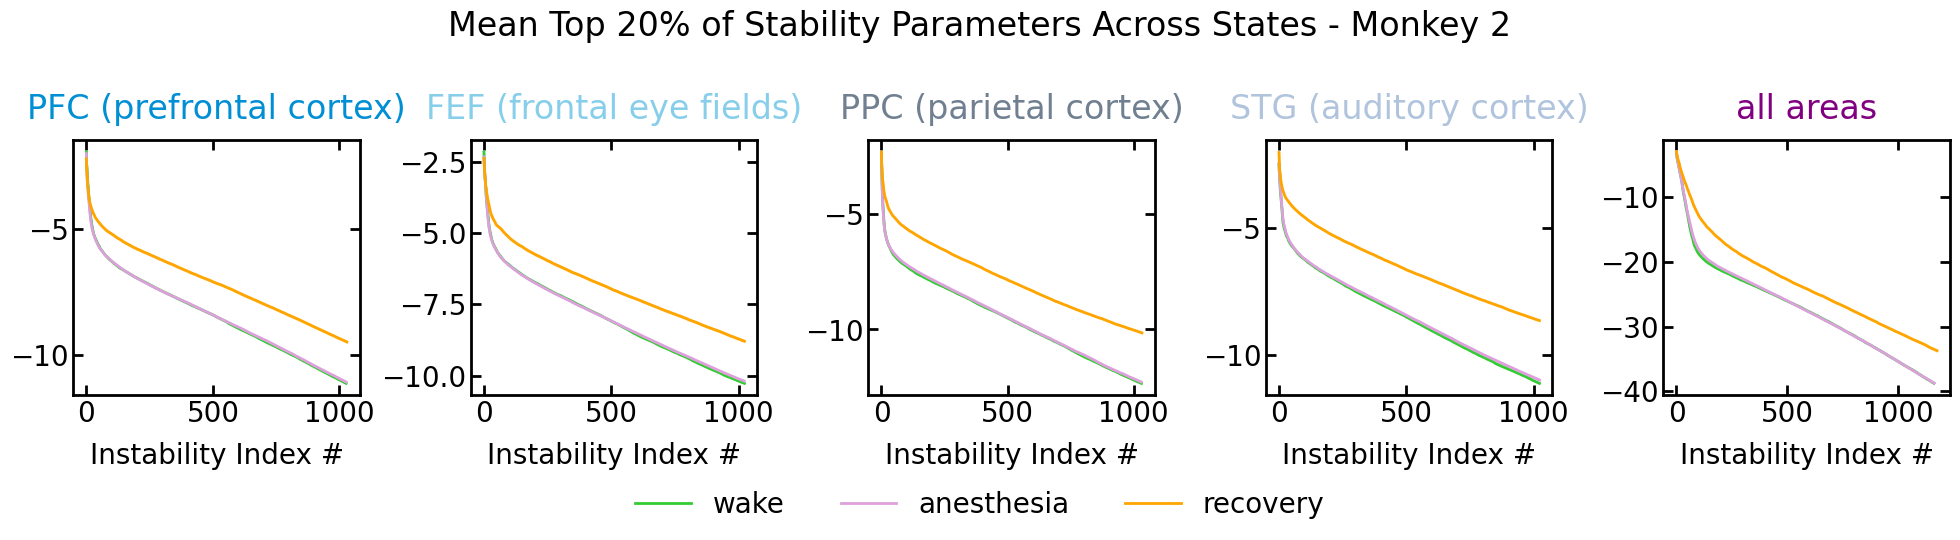

In [108]:
areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']

percentile_low = 0
percentile_high = 20

if percentile_low == 0:
    percentile_str = f"Top {percentile_high}% of Stability Parameters"
else:
    percentile_str = f"Top {percentile_low}% to {percentile_high}% of Stability Parameters"

# figsize= (12, 8)
figsize=(20, 5)
fig, axs = plt.subplots(1, len(areas), figsize=figsize)
spectra = {}
for i in range(len(areas)):
#         ax = axs[int(i/2)][i%2]
    ax = axs[i]
    area = areas[i]
    lns = []
    spectra[area] = {}
    for section in ['wake', 'anesthesia', 'recovery']:
#         for section in ['wake', 'anesthesia']:
        section_inds = np.logical_and(results_dict[area].start_time >= section_times[section][0], results_dict[area].start_time < section_times[section][1])
        min_length = np.min(results_dict[area][section_inds].stability_params.apply(lambda x: int(len(x)*percentile_high/100) - int(len(x)*percentile_low/100)))
        full_spectrum = np.vstack(results_dict[area][section_inds].stability_params.apply(lambda x: x[int(len(x)*percentile_low/100):int(len(x)*percentile_low/100) + min_length]).to_numpy())
        mean_spectrum = full_spectrum.mean(axis=0)
        se_spectrum = full_spectrum.std(axis=0)/np.sqrt(len(section_inds))
        lns += ax.plot(mean_spectrum, c=section_colors[section], label=section)
        ax.fill_between(np.arange(len(mean_spectrum)), mean_spectrum - se_spectrum, mean_spectrum + se_spectrum, color=section_colors[section], alpha=0.4)
        if section in ['wake', 'anesthesia']:
            spectra[area][section] = full_spectrum
    ax.set_title(area_labels[area], c=area_colors[area])
    ax.set_xlabel("Instability Index #")
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.01), loc='center', ncol=3)
monkey_num = 2 if 'Jones' in session else 1
plt.suptitle(f"Mean {percentile_str} Across States - Monkey {monkey_num}")
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, f"neural_ret2.png"), transparent=True, bbox_inches='tight')
plt.show()

# Plot 3

In [114]:
len(np.histogram(stab_params.iloc[t], bins=bins, density=True)[0])

40

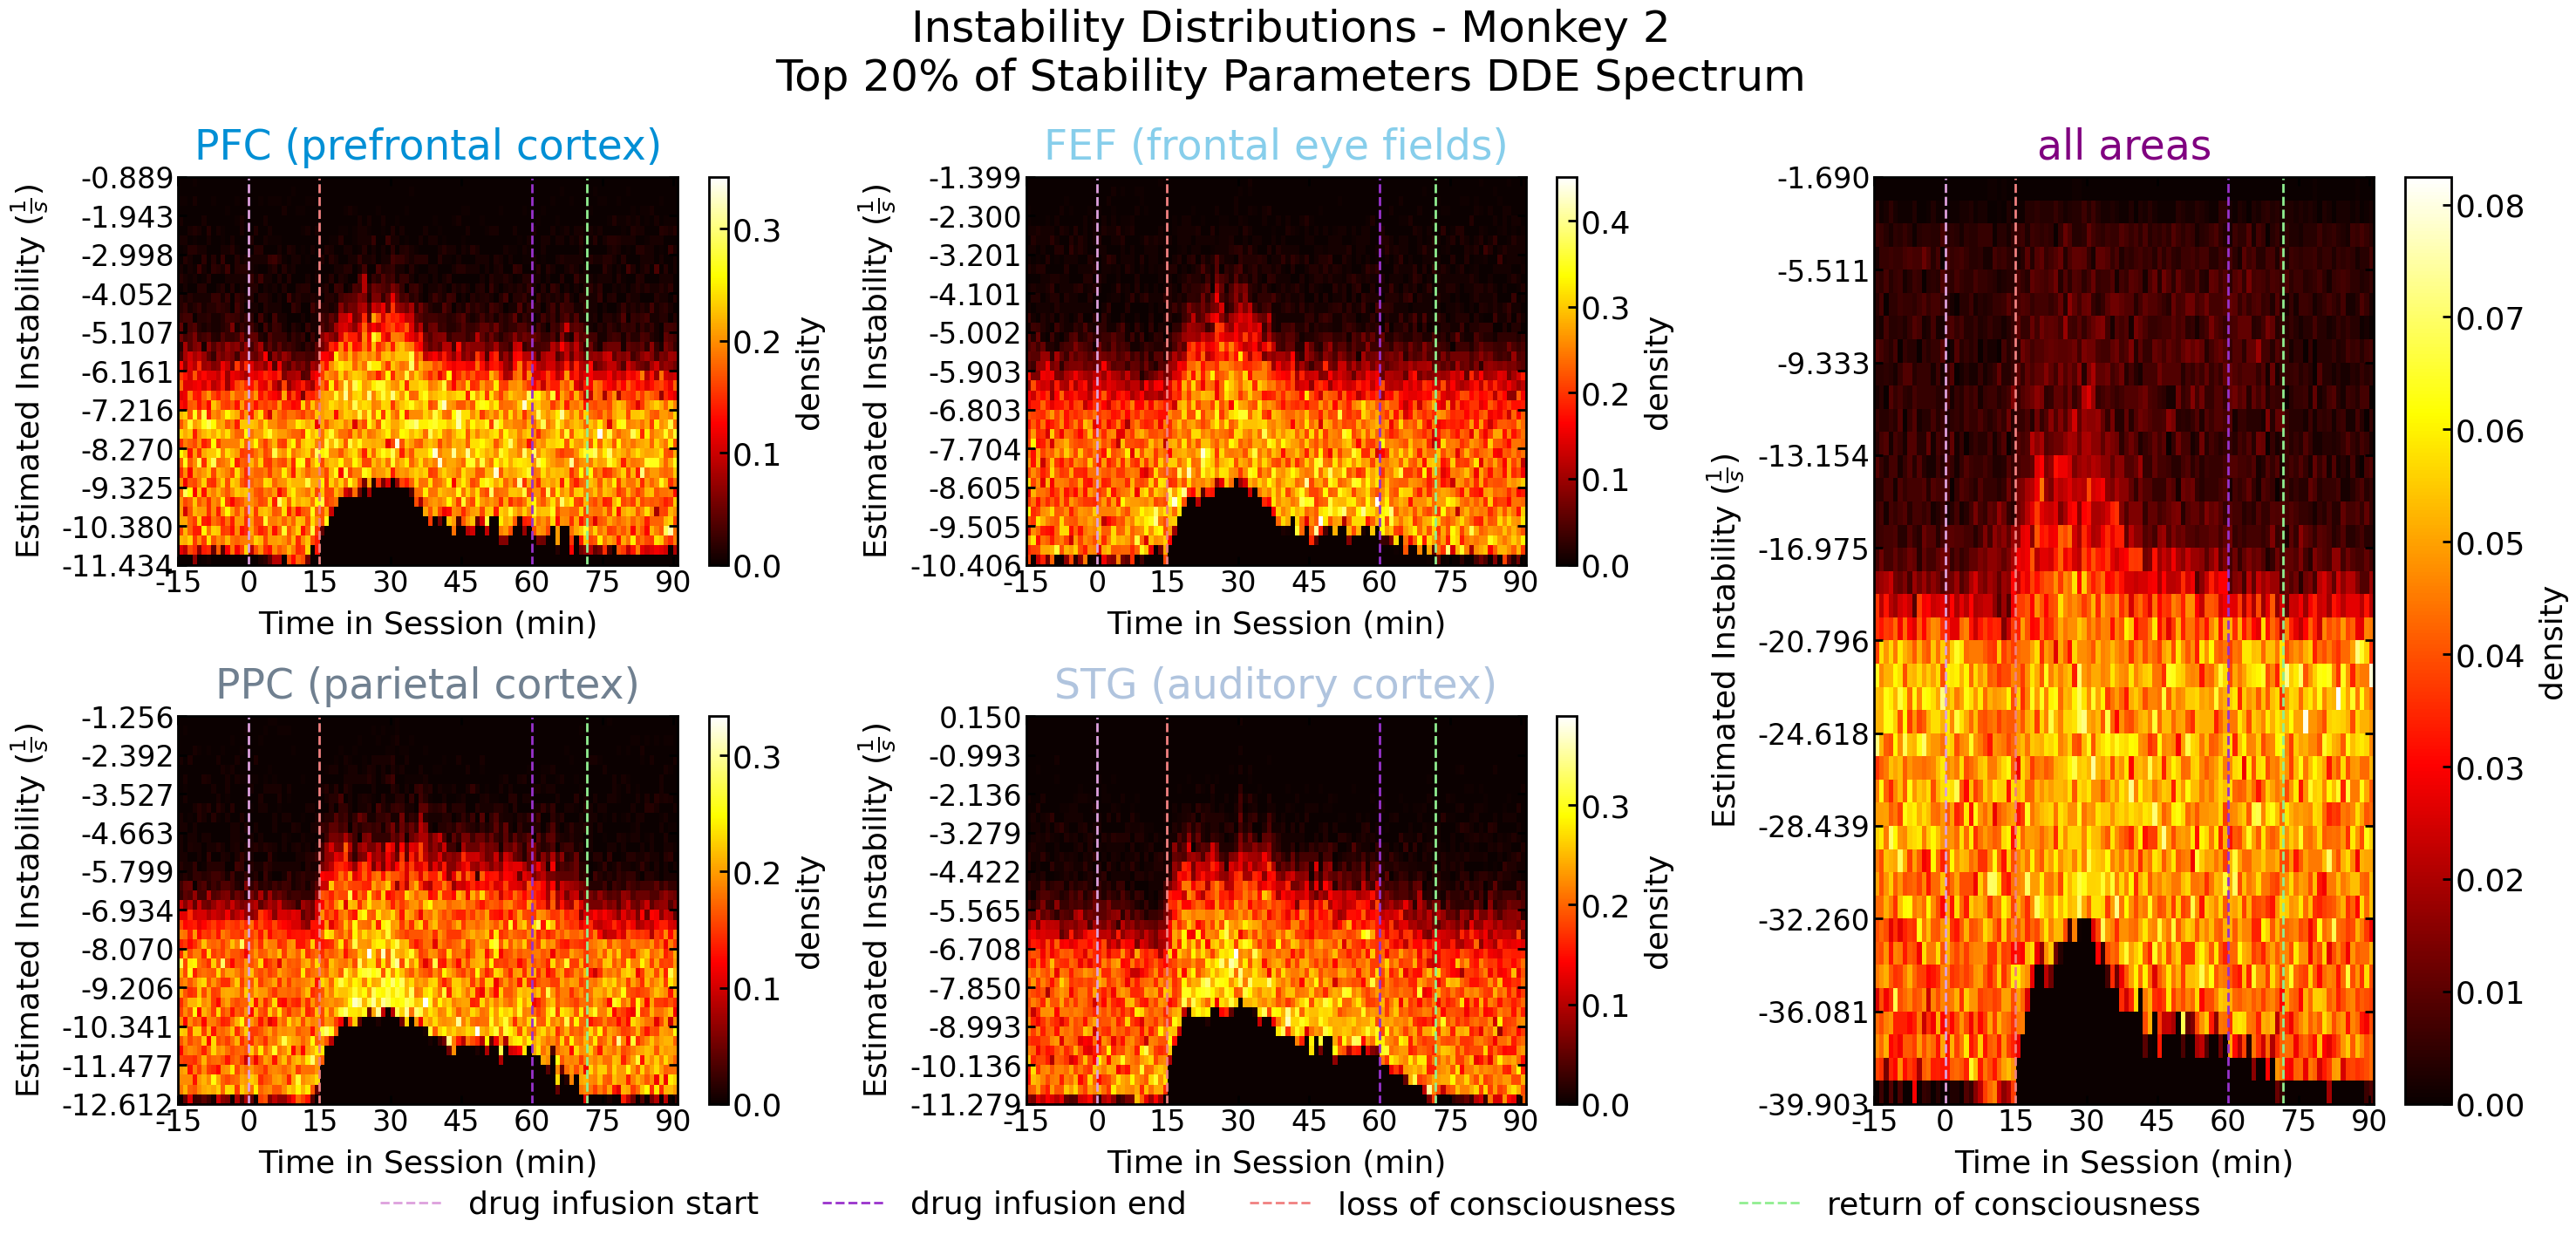

In [128]:
percentile_low = 0
percentile_high = 20

filter_inds = np.logical_and(results_dict[list(results_dict.keys())[0]].start_time >= session_info['drugStart'][0] - 15*60, results_dict[list(results_dict.keys())[0]].start_time <= eyes_open + 20*60)
time_vals = (results_dict[list(results_dict.keys())[0]][filter_inds].start_time - session_info['drugStart'][0])/60

start_times = results_dict[list(results_dict.keys())[0]].start_time
stride = start_times.iloc[1] - start_times.iloc[0]

if percentile_low == 0:
    percentile_str = f"Top {percentile_high}% of Stability Parameters"
else:
    percentile_str = f"Top {percentile_low}% to {percentile_high}% of Stability Parameters"

# fig = plt.figure(figsize=(38, 7))

areas = ['CPB', '7b', 'FEF', 'vlPFC', 'all']

fig = plt.figure(figsize=(30, 14))
for i, area in enumerate(areas):
    if area == 'all':
        plt.subplot(1, 3, 3)
    else:
        if area == 'vlPFC':
            index = 1
        elif area == 'FEF':
            index = 2
        elif area == '7b':
            index = 4
        elif area == 'CPB':
            index = 5
        plt.subplot(2, 3, index)
    stab_params = results_dict[area][filter_inds].stability_params.apply(lambda x: x[int(percentile_low*len(x)/100):int(percentile_high*len(x)/100)])
    emin = np.hstack(stab_params.to_numpy()).min()
    emax = np.hstack(stab_params.to_numpy()).max()                                                                        
                                                                         
    bin_nums = 40
    bins = [(emax - emin)*i/bin_nums + emin for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((len(stab_params), bin_nums))
    density=True
    for t in range(criticality_prob_dist.shape[0]):
        if not density:
            criticality_prob_dist[t] = np.histogram(stab_params.iloc[t], bins=bins)[0]
        else:
            criticality_prob_dist[t] = [d for d in np.histogram(stab_params.iloc[t], bins=bins, density=True)[0]]
    
    plt.pcolormesh(criticality_prob_dist.T, cmap='hot')
    # plt.xticks([int(i*60/stride) for i in np.arange(0, 120, 20)], np.arange(0, 120, 20))
    plt.yticks(np.arange(0, bin_nums + 1, 4), [f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 4)]], fontsize=24)
#     num_xticks = 7
#     xtick_step = int(criticality_prob_dist.shape[0]/num_xticks)
    x_step = 15 # mins
    xtick_locs = np.arange(0, int(criticality_prob_dist.shape[0]*stride/60), x_step)
    plt.xticks(np.arange(0, int(criticality_prob_dist.shape[0]*stride/60), x_step), [int(loc*60/stride) - 15 for loc in xtick_locs], fontsize=24)
    plt.xlabel('Time in Session (min)', fontsize=26)
    plt.ylabel('Estimated Instability' + r' ($\frac{1}{s}$)', fontsize=26)
    plt.title(area_labels[area], c=area_colors[area], fontsize=34)
    lns = []
    lns.append(plt.axvline((session_info['drugStart'][0] - session_info['drugStart'][0])/60 + 15, color='plum', linestyle='--', label=f"drug infusion start"))
    lns.append(plt.axvline((session_info['drugEnd'][1] - session_info['drugStart'][0])/60 + 15, color='darkorchid', linestyle='--', label=f"drug infusion end"))
    lns.append(plt.axvline((eyes_close - session_info['drugStart'][0])/60 + 15, linestyle='--', color='lightcoral', label='loss of consciousness'))
    lns.append(plt.axvline((eyes_open - session_info['drugStart'][0])/60 + 15, linestyle='--', color='lightgreen', label='return of consciousness'))
    cbar = plt.colorbar()
    cbar.set_label(label='# of modes' if not density else 'density', size=26)
    cbar.ax.tick_params(labelsize=26)
monkey_num = 2 if 'Jones' in session else 1
plt.suptitle(f"Instability Distributions - Monkey {monkey_num}\n{percentile_str} DDE Spectrum", fontsize=36)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, ncol=4, bbox_to_anchor=(0.5, 0), fontsize=26, loc='center')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, f"neural_ret3.png"), transparent=True, bbox_inches='tight')
plt.show()

AttributeError: 'Colorbar' object has no attribute 'set_axis_label_font'